In [3]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


so we wanna make sure this actually saved

In [6]:
import pandas as pd

df = pd.read_parquet("rare__final_merged_dataset.parquet")
print(df.head())

        date  layman__oil_price  layman__gas_price  layman__mortgage_rate  \
0 1997-01-01              27.65              1.316                   8.25   
1 1997-02-01              27.65              1.316                   8.25   
2 1997-03-01              27.65              1.316                   8.25   
3 1997-04-01              27.65              1.316                   8.25   
4 1997-05-01              27.65              1.316                   8.25   

   layman__housing_prices  layman__grocery_index  layman__retail_sales  \
0                   100.0                  166.3              268044.0   
1                   100.0                  166.3              268044.0   
2                   100.0                  166.3              268044.0   
3                   100.0                  166.3              268044.0   
4                   100.0                  166.3              268044.0   

   layman__electricity_cost_index  layman__used_car_prices  \
0                           11

confirm it is indeed big enough for training..

In [9]:
df.shape[0]

8292

In [11]:
# summary = df.describe().T
# summary.to_csv("eda_describe_summary.csv") ### already obtained

we wanna now downselect to the top 16 features for our lil models to nom on

so we will do some eda and visualize the data a bit

to get an intuition

In [14]:
### we needed to switch things up to prevent crashing since the dataframe is massive ###
import seaborn as sns
import matplotlib.pyplot as plt

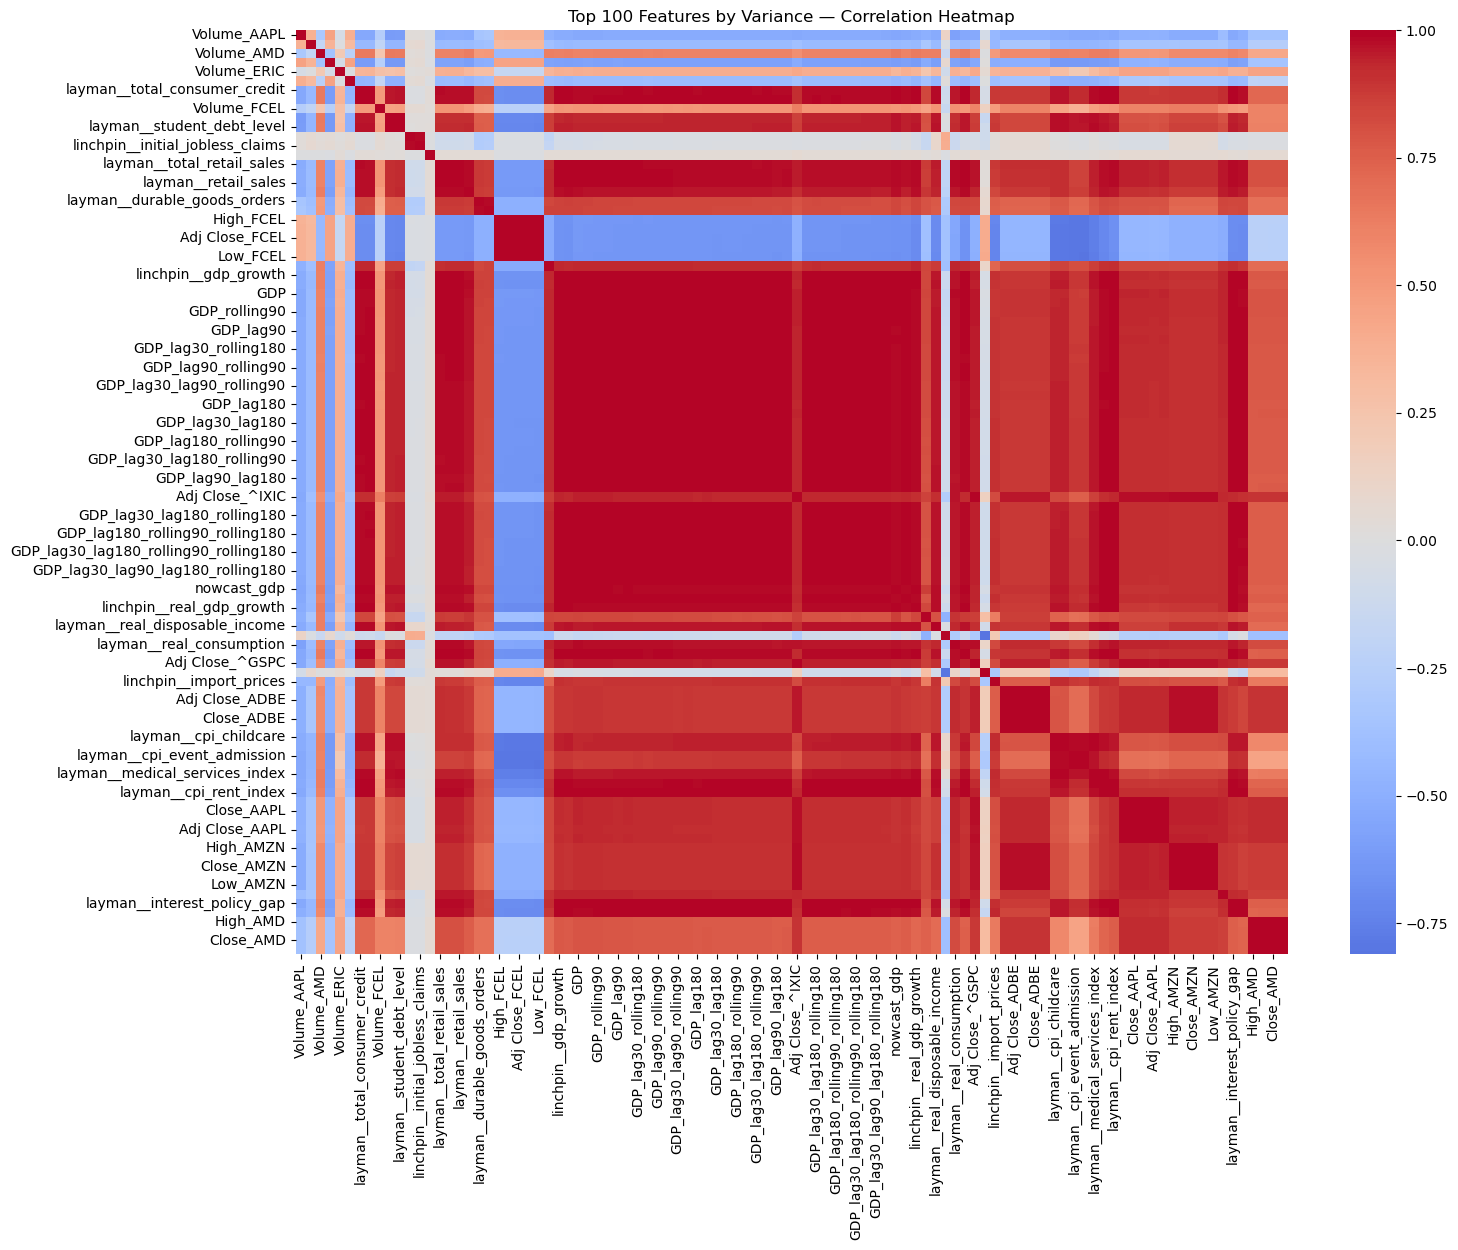

In [16]:
# --- Notebook Cell 6: Safe Correlation Heatmap ---
# Visualize correlation heatmap from top 100 high-variance features
numeric_df = df.drop(columns=["date"], errors="ignore")

if numeric_df.shape[1] > 100:
    top_var_cols = numeric_df.var().sort_values(ascending=False).head(100).index
    corr = numeric_df[top_var_cols].corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Top 100 Features by Variance — Correlation Heatmap")
    plt.show()
else:
    corr = numeric_df.corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Feature Correlation Heatmap")
    plt.show()

- heatmap suggests it’s safe to use PCA or feature agglomeration — there’s high redundancy
- Blue areas (negative correlations) appear less often — likely where economic activity moves inversely (e.g. VIX vs. S&P)
- Bright white crosshair pattern (correlation = 0) shows variables orthogonal to others (these might be good candidates for independent signals)
- dense red blocks (correlation ≈ 1.0) for large portions of your top 100 features
- many features are highly correlated with one another (multicollinearity)
- Variants of the same economic signal (e.g. GDP_lag30, lag90, rolling180)
- Similar stock indicators (e.g. Close_AAPL, Adj Close_AAPL, Low_AAPL, High_AAPL)
- After PCA, keep components explaining 90–95% of variance
- feature selection tools like: VarianceThreshold(), SelectKBest(), RandomForestClassifier.feature_importances_


In [ ]:
# ### VIF Variance Inflation Factor
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# import pandas as pd

# merged = df

# # Drop date, add constant, and limit to numeric features
# X = merged.drop(columns=['date'], errors='ignore')
# X = X.select_dtypes(include='number')  # keep only numeric
# X = add_constant(X)  # adds intercept term

# # Compute VIF
# vif_df = pd.DataFrame()
# vif_df['feature'] = X.columns
# vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # Sort and preview
# vif_df = vif_df.sort_values(by='VIF', ascending=False)
# print(vif_df.head(20))

### too heavy, use variance informed-optimization of calculating vif

In [18]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant

# # --- Step 1: Select Top-N High Variance Features ---
# N = 100  # You can raise this to 250 or more if your machine handles it
# X = df.drop(columns=['date'], errors='ignore').select_dtypes(include='number')
# top_var_cols = X.var().sort_values(ascending=False).head(N).index
# X_subset = X[top_var_cols]

# # --- Step 2: Compute VIF ---
# X_vif = add_constant(X_subset)
# vif_df = pd.DataFrame()
# vif_df['feature'] = X_vif.columns
# vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# # --- Step 3: Drop Features with High VIF (Optional) ---
# # Keep constant and features with VIF <= 10
# keep_cols = vif_df[vif_df['VIF'] <= 10]['feature'].tolist()
# if 'const' in keep_cols:
#     keep_cols.remove('const')  # drop intercept again
# X_clean = X_subset[keep_cols]

# # --- Step 4: Result Summary ---
# print(f"Original features checked: {X_subset.shape[1]}")
# print(f"Remaining after VIF <= 10: {X_clean.shape[1]}")
# print("\nTop features surviving VIF filter:\n", X_clean.columns.tolist())

# # --- Optional: Save VIF Report ---
# vif_df.to_csv("vif_report.csv", index=False)

# # X_clean is now ready for PCA or model input

### gotcha.. only saves a few.. and we want more than that duh

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Original features checked: 100
Remaining after VIF <= 10: 8

Top features surviving VIF filter:
 ['Volume_AAPL', 'Volume_AMZN', 'Volume_AMD', 'Volume_CSCO', 'Volume_ERIC', 'Volume_ADBE', 'Volume_FCEL', 'Volume_FORD']


In [20]:
# # Step 5: Replenish to top-N after VIF filter
# desired_total = 100
# remaining_pool = [col for col in top_var_cols if col not in keep_cols]
# additional_cols = []

# for col in remaining_pool:
#     if len(keep_cols) + len(additional_cols) >= desired_total:
#         break
#     # Check if this column is not too correlated with those already kept
#     corr_with_kept = X_subset[keep_cols + additional_cols].corrwith(X_subset[col]).abs().max()
#     if corr_with_kept < 0.95:  # loose threshold
#         additional_cols.append(col)

# final_cols = keep_cols + additional_cols
# X_final = X_subset[final_cols]

# print(f"\n🎯 Final feature set with {len(X_final.columns)} features selected.")
# print(X_final.columns.tolist())

### kinda closer


🎯 Final feature set with 21 features selected.
['Volume_AAPL', 'Volume_AMZN', 'Volume_AMD', 'Volume_CSCO', 'Volume_ERIC', 'Volume_ADBE', 'Volume_FCEL', 'Volume_FORD', 'layman__total_consumer_credit', 'layman__initial_unemployment_claims', 'layman__durable_goods_orders', 'High_FCEL', 'linchpin__nonfarm_payrolls', 'Adj Close_^IXIC', 'layman__job_openings_total', 'layman__part_time_econ_reasons', 'linchpin__housing_starts', 'linchpin__import_prices', 'layman__cpi_event_admission', 'layman__housing_prices', 'High_AMD']


In [22]:
# Start with your VIF-cleaned features
X = df.drop(columns=['date'], errors='ignore').select_dtypes(include='number')
top_var_cols = X.var().sort_values(ascending=False).head(300).index  # start with larger base
X_subset = X[top_var_cols]

# Compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_subset)
vif_df = pd.DataFrame()
vif_df['feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

keep_cols = vif_df[(vif_df['VIF'] <= 10) & (vif_df['feature'] != 'const')]['feature'].tolist()
remaining_pool = [col for col in top_var_cols if col not in keep_cols]

# --- Loop until we get to 100 features ---
final_cols = keep_cols.copy()

for col in remaining_pool:
    if len(final_cols) >= 100:
        break
    # Check for collinearity with current final set
    max_corr = X_subset[final_cols].corrwith(X_subset[col]).abs().max()
    if pd.isna(max_corr) or max_corr < 0.95:
        final_cols.append(col)

X_final = X_subset[final_cols]

print(f"✅ Final feature set size: {len(X_final.columns)}")
print("🎯 Feature names:", X_final.columns.tolist())

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


✅ Final feature set size: 83
🎯 Feature names: ['Volume_AAPL', 'Volume_AMZN', 'Volume_AMD', 'Volume_CSCO', 'Volume_ERIC', 'Volume_ADBE', 'Volume_FCEL', 'Volume_FORD', 'Rolling_Std_30d', 'news_coverage_volatility_index', 'tiktok_recession_hashtag_velocity', 'layman__total_consumer_credit', 'layman__initial_unemployment_claims', 'layman__durable_goods_orders', 'High_FCEL', 'linchpin__nonfarm_payrolls', 'Adj Close_^IXIC', 'layman__job_openings_total', 'layman__part_time_econ_reasons', 'linchpin__housing_starts', 'linchpin__import_prices', 'layman__cpi_event_admission', 'layman__housing_prices', 'High_AMD', 'layman__water_bill_index', 'High_FORD', 'layman__electricity_cost_index', 'layman__cpi_airfare', 'layman__public_transit_fares', 'layman__oil_price', 'tail_risk_score', 'twitter_macro_fear_score', 'layman__cpi_used_cars', 'High_ERIC', 'reddit_finance_sentiment', 'inflation', '10y_treasury_yield', 'High_CSCO', 'Consumer Sentiment', 'interest rates', 'linchpin__consumer_sentiment_index', 

In [24]:
# Grab extra low-correlation features from what's left
extras = [col for col in top_var_cols if col not in final_cols]
extra_pool = []

for col in extras:
    if len(extra_pool) + len(final_cols) >= 100:
        break
    corr_with_main = X_subset[final_cols].corrwith(X_subset[col]).abs().max()
    if pd.isna(corr_with_main) or corr_with_main < 0.85:  # relaxed threshold
        extra_pool.append(col)

# Add them in a separate set
X_extended = X_subset[final_cols + extra_pool]
print(f"🚀 Extended feature set size: {X_extended.shape[1]}")

🚀 Extended feature set size: 83


In [26]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# X = df.drop(columns=["date"])
# X_scaled = StandardScaler().fit_transform(X)

# pca = PCA(n_components=16)
# pca.fit(X_scaled)

# import numpy as np
# top_features_idx = np.argsort(-np.abs(pca.components_[0]))[:16]
# top_features = X.columns[top_features_idx]
# print("Top 16 PCA-selected features:", list(top_features))

In [28]:
### SAVE ###

# Combine with date column
X_final_with_date = pd.concat([df['date'], X_final], axis=1)

# Save to disk
X_final_with_date.to_csv("selected_features_83.csv", index=False)
X_final_with_date.to_parquet("selected_features_83.parquet", index=False)

print("✅ Saved 83 selected features with date for downstream use.")

✅ Saved 83 selected features with date for downstream use.


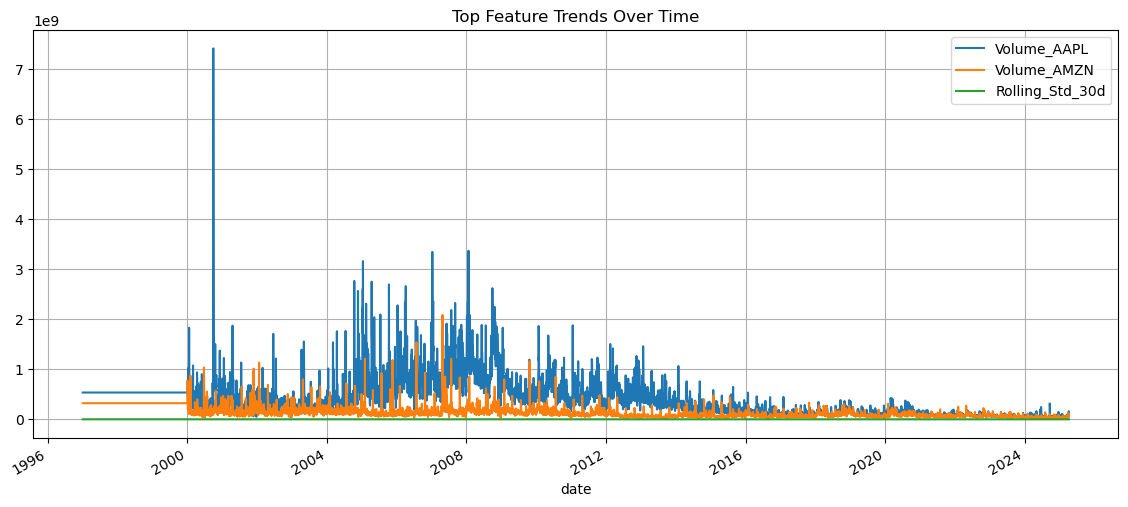

In [32]:
# 🔍 A. Time Series Exploration
# 	•	Plot feature trends over time
# 	•	Highlight recession / shock zones

# import matplotlib.pyplot as plt

# Example: plot top 3 features
X_final_with_date.set_index('date')[['Volume_AAPL', 'Volume_AMZN', 'Rolling_Std_30d']].plot(figsize=(14, 6))
plt.title("Top Feature Trends Over Time")
plt.grid()
plt.show()

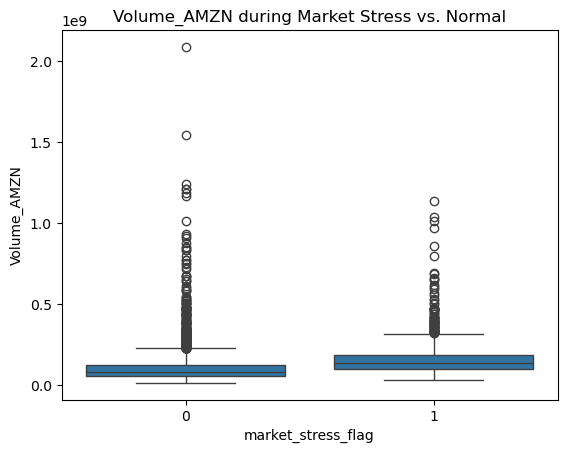

In [34]:
# 🔁 B. Compare Periods: Normal vs. Recession vs. Shock

# Using your flags:

import seaborn as sns

# Join flags back in
merged_subset = pd.merge(X_final_with_date, df[['date', 'market_stress_flag', 'market_shock_flag']], on='date', how='left')

# Boxplot of a key variable
sns.boxplot(x='market_stress_flag', y='Volume_AMZN', data=merged_subset)
plt.title("Volume_AMZN during Market Stress vs. Normal")
plt.show()

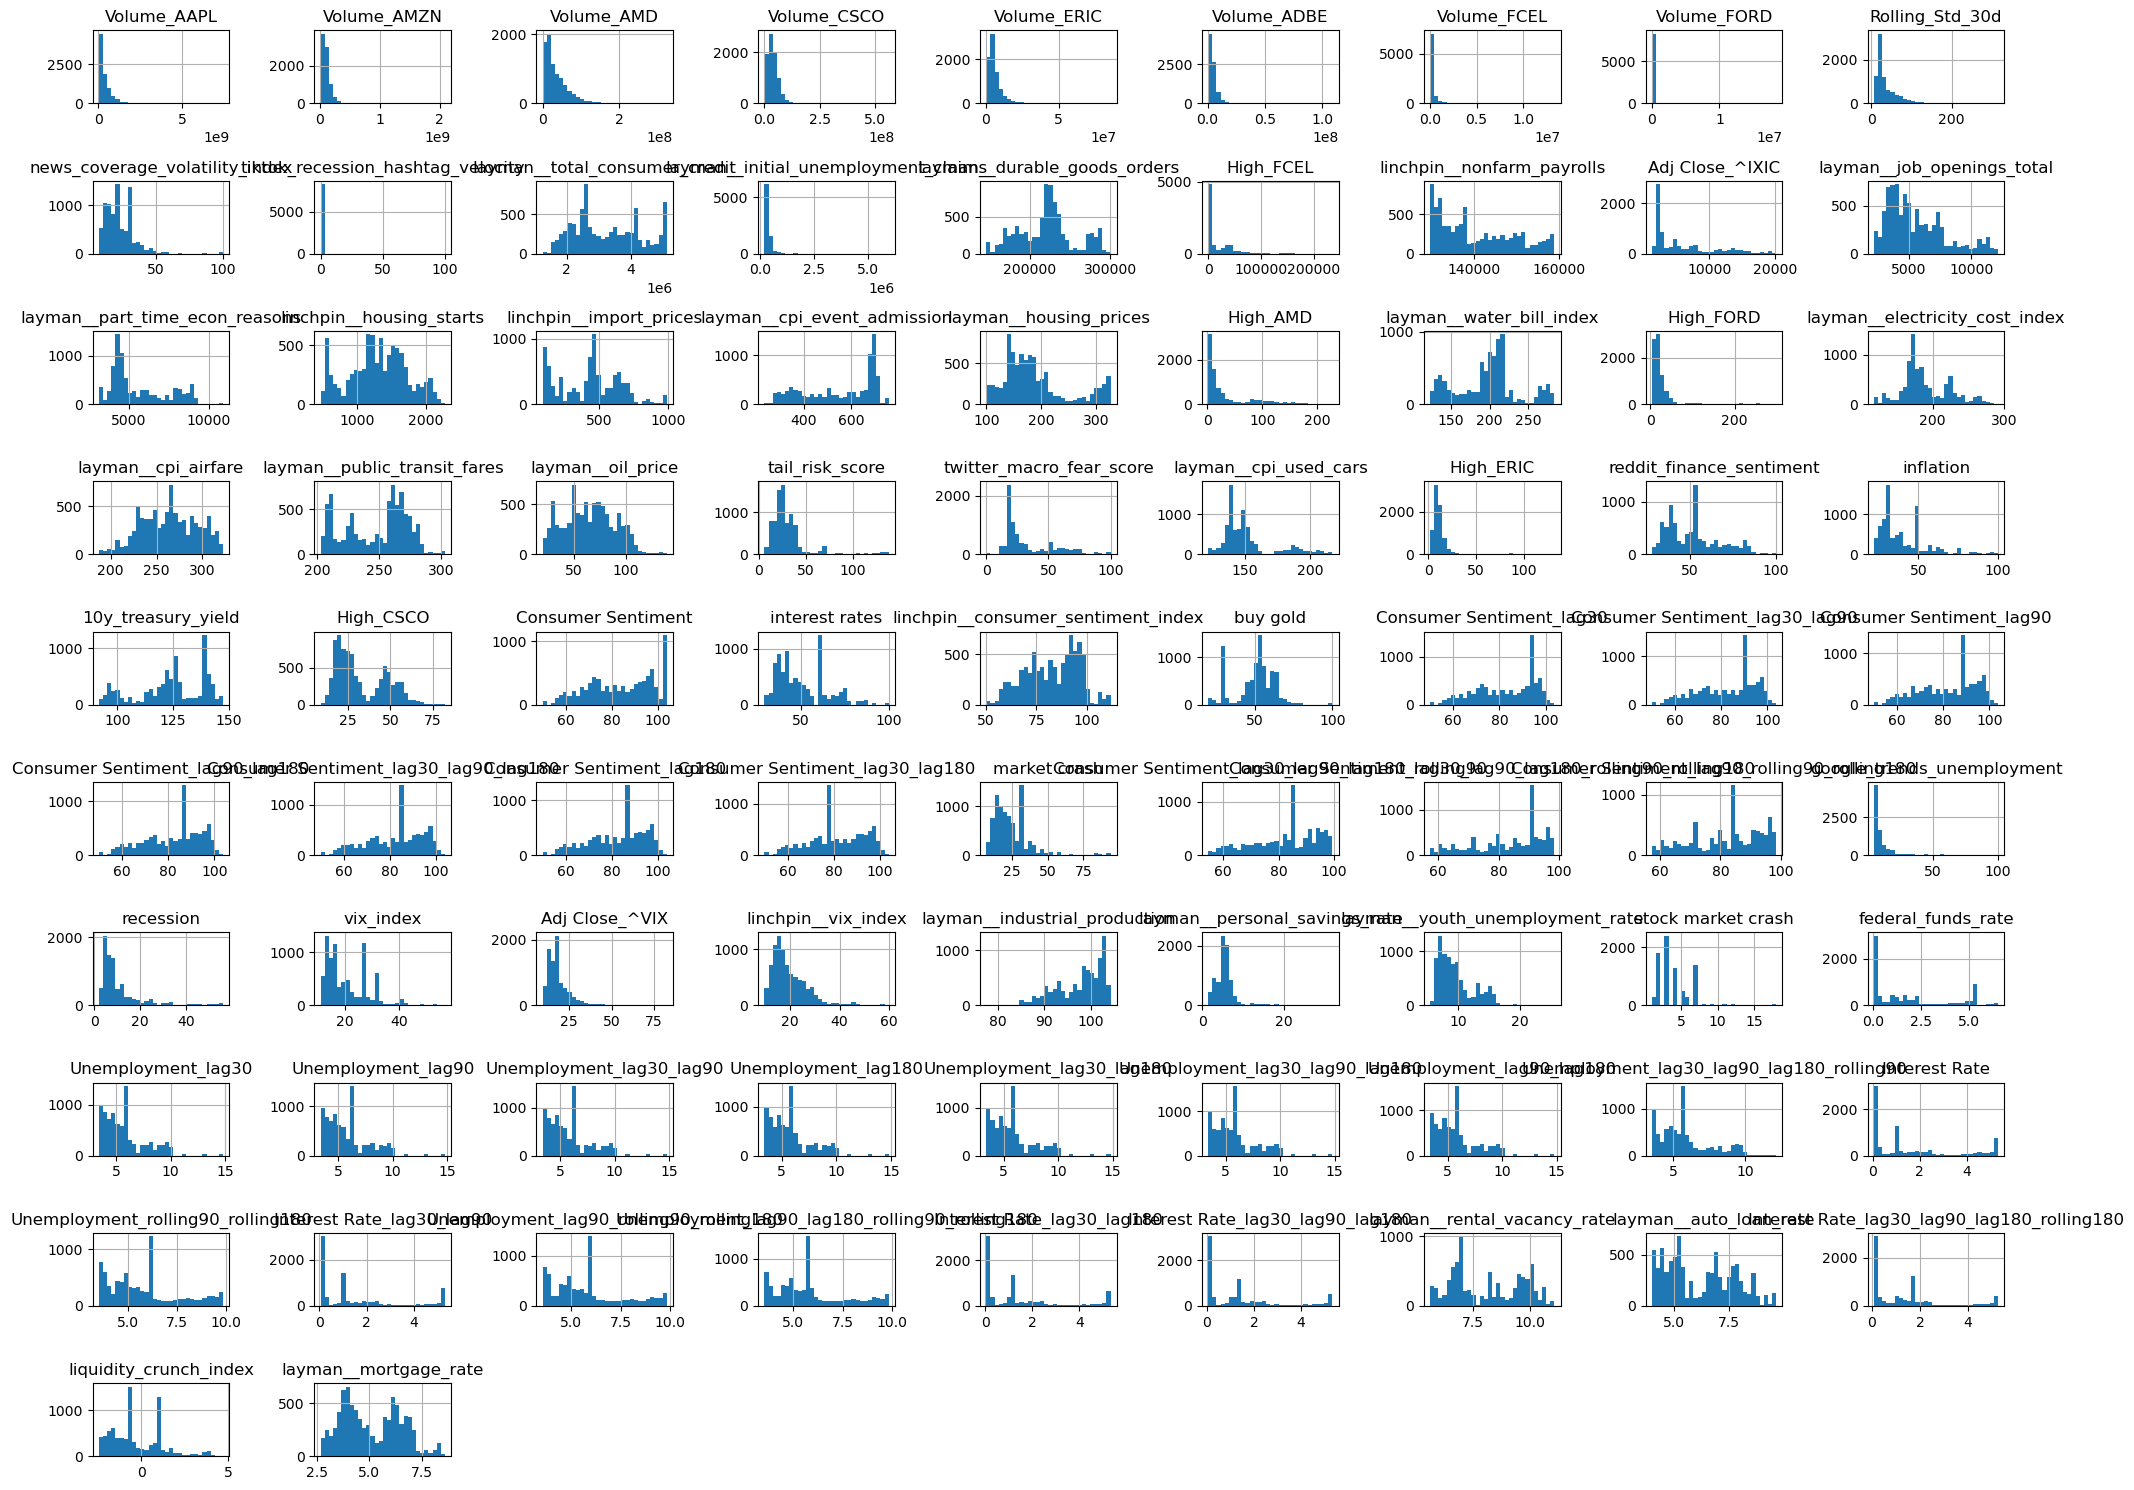

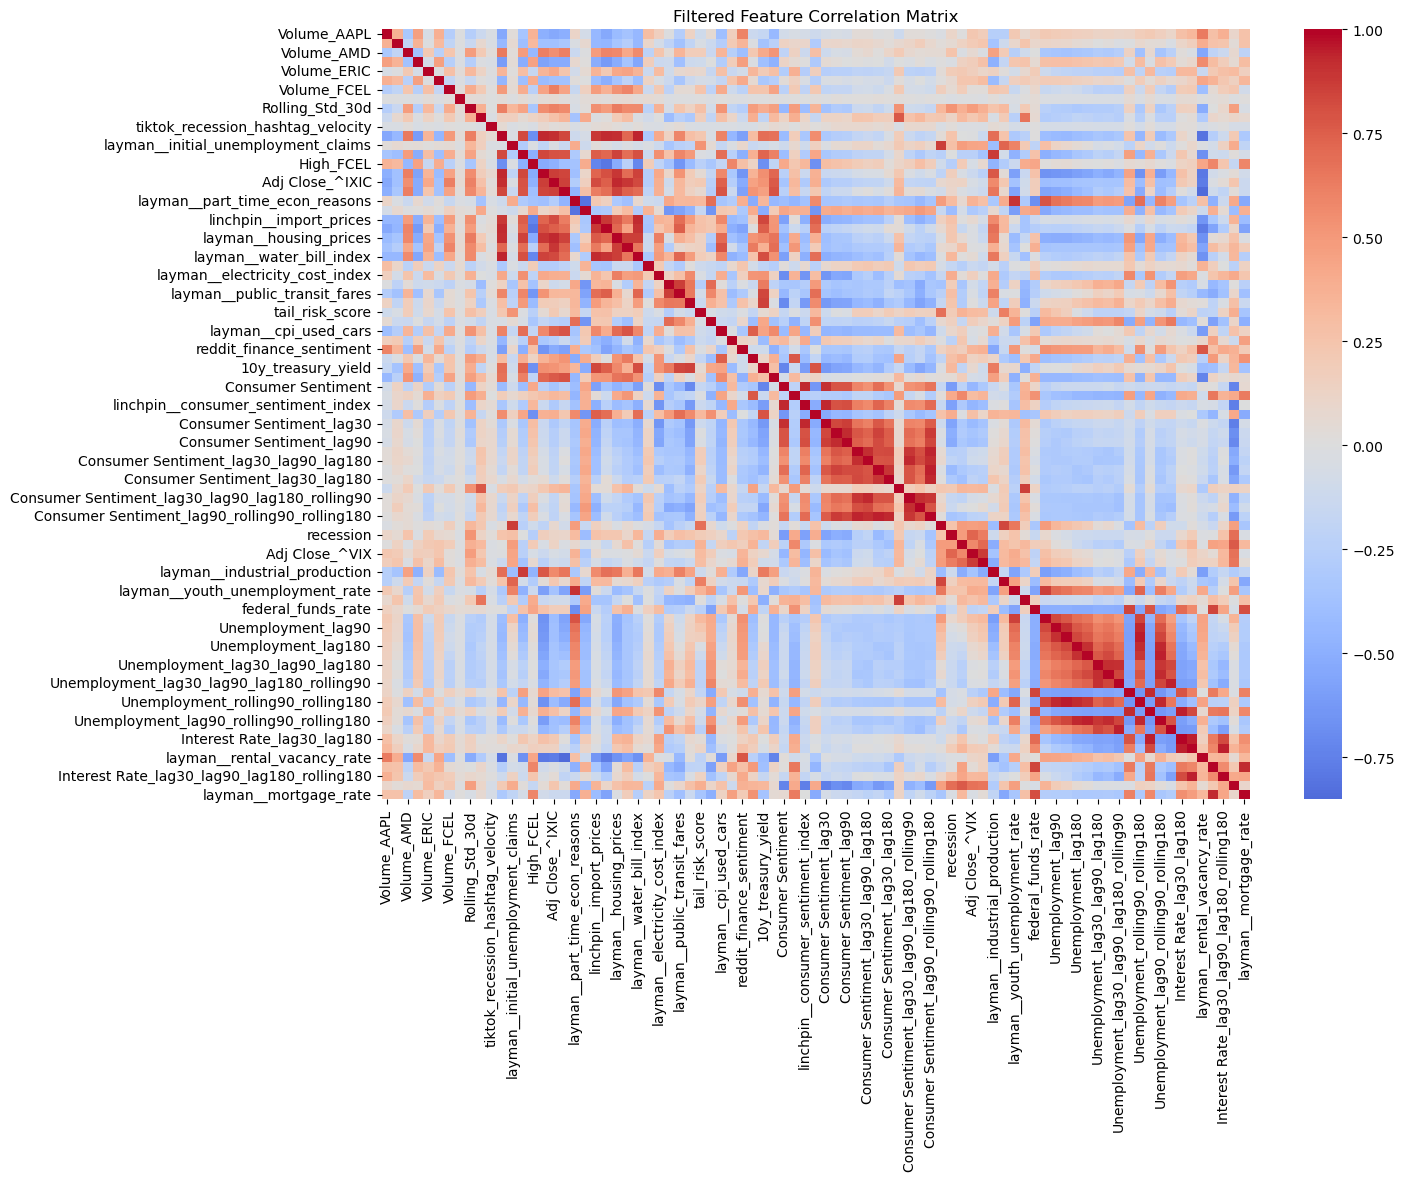

In [38]:
# 🧪 C. Distribution & Correlation Analysis
# Histogram grid
X_final.hist(figsize=(20, 15), bins=30)
plt.tight_layout()
plt.show()

# Focused correlation matrix
import seaborn as sns
corr = X_final.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Filtered Feature Correlation Matrix")
plt.show()